2020-05-26 v1 LSW@NCHC

2020-08-13 v2

2020-08-31 v3_tf.data_Loadandpreprocessdata_image_tf2.3to2.2_twcc_clean


### 2020-08-31 <font color=#FF6600>Move to 'clean NB' for trail, leave original NB for course used.</font>

### 2020-09-14 <font color=#FF6600>Fixed BN in fine-tune training, added dropout at top-layer.</font>
### 2020-09-16 <font color=#FF6600>Added tf.distribute.Strategy with multi-GPUs for speedup training.</font>
### 2020-09-17 <font color=#FF6600>Added step learning rate, tensorboard callback.</font>
### 2020-11-27 <font color=#Ff1100>For leaf classfiy and TF2.3.1 testing.</font>
* re-split the train-image to directory label form.

## 0. Install pkgs for TWCC

In [1]:
%%time
!sh install_env.sh

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic InRelease [242 kB]
Get:3 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [1790 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]      
Get:5 http://security.ubuntu.com/ubuntu bionic-security/multiverse amd64 Packages [15.8 kB]3m
Get:6 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packages [226 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1366 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]    
Get:9 http://archive.ubuntu.com/ubuntu bionic/multiverse amd64 Packages [186 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic/universe amd64 Packages [11.3 MB]
Get:11 http://archive.ubuntu.com/ubuntu bionic/restricted amd64 Packages [13.5 kB]m
Get:12 http://archive.ubuntu.com/ubuntu bionic/main amd64 Packages [1344 kB]   
Get:13 http:

## 1. Download dataset

In [2]:
from datetime import datetime

import tensorflow as tf


# 自動調節tf.data管道
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import cv2
import vlogging
import seaborn as sns

print("tf version : ", tf.__version__)

# leaf
import pandas as pd
import shutil
from tqdm import tqdm
import math
import tensorflow.keras.backend as K

# 下載資料,(flower ~218MB)
# keras下載位置預設為~/user/.keras/datasets/
# !ls /Users/lsw/.keras/datasets/flower_photos
# LICENSE.txt daisy  dandelion  roses  sunflowers  tulips

# flood
# origin = 'https://drive.narlabs.org.tw/webrelay/directdownload/txp8hb31v67tl47f/?dis=10014&fi=2683826'
# data_dir = tf.keras.utils.get_file(origin=origin, fname='floods', untar=True)
# data_dir = '/home/u3148947/.keras/datasets/floods' #不下載，直接sftp上傳
data_dir = '/home/u3148947/.keras/datasets/leaf/leaf_labels/' #不下載，直接sftp上傳

# flowers
# origin = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
# data_dir = tf.keras.utils.get_file(origin=origin, fname='flower_photos', untar=True)
# data_dir = '/home/u3148947/.keras/datasets/flower_photos' #不下載，直接sftp上傳

# uni
# data_dir = '/home/u3148947/.keras/datasets/uni' #不下載，直接sftp上傳


""" # leaf不適用資料夾即label模式，另外分好
data_dir = pathlib.Path(data_dir) # 注意！這把原本路徑轉換成PosixPath的物件=PosixPath('~/user/.keras/datasets/')不是原始的string路徑。
image_count = len(list(data_dir.glob('*/*.jpg')))
# CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt" and not item.name.startswith('.')])
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))

# todo:這裡可以幫學員回憶python強大的表示式處理

# data information
print("Save to :", data_dir)
print("Count images: ", image_count)
print("Class names : ", class_names)
print("Class number: ", len(class_names))
"""

# leaf
data_dir = pathlib.Path(data_dir) # 注意！這把原本路徑轉換成PosixPath的物件=PosixPath('~/user/.keras/datasets/')不是原始的string路徑。
image_count = len(list(data_dir.glob('*/*.jpg')))
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))

# data information
print("Save to :", data_dir)
print("Count images: ", image_count)
print("Class names : ", class_names)
print("Class number: ", len(class_names))


tf version :  2.3.1
Save to : /home/u3148947/.keras/datasets/leaf/leaf_labels
Count images:  21397
Class names :  ['CBB' 'CBSD' 'CGM' 'CMD' 'Healthy']
Class number:  5


## Split image to labels dir

leaf不適用資料夾即label模式，需另外先分好資料夾

* Center croped may be helped

In [3]:
leaf_dir = '/home/u3148947/.keras/datasets/leaf/'
leaf_dir

'/home/u3148947/.keras/datasets/leaf/'

In [4]:
""" num to disease map json
{"0": "Cassava Bacterial Blight (CBB)", 
"1": "Cassava Brown Streak Disease (CBSD)", 
"2": "Cassava Green Mottle (CGM)", 
"3": "Cassava Mosaic Disease (CMD)", 
"4": "Healthy"}
"""
# CLASSES = ['Cassava Bacterial Blight', 
#            'Cassava Brown Streak Disease', 
#            'Cassava Green Mottle', 
#            'Cassava Mosaic Disease', 
#            'Healthy']
CLASSES = ['CBB', 
           'CBSD', 
           'CGM', 
           'CMD', 
           'Healthy']

In [5]:
# check lables
for i in CLASSES:
    print(i)
for i in range(5):
    print(i, CLASSES[i])

CBB
CBSD
CGM
CMD
Healthy
0 CBB
1 CBSD
2 CGM
3 CMD
4 Healthy


In [6]:
# mkdirs if not exist

train_labels = leaf_dir + "leaf_labels/"
if not os.path.exists(train_labels):
    os.mkdir(train_labels)

for dir in CLASSES:
    dir_path = train_labels + dir
    print(dir_path)
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

/home/u3148947/.keras/datasets/leaf/leaf_labels/CBB
/home/u3148947/.keras/datasets/leaf/leaf_labels/CBSD
/home/u3148947/.keras/datasets/leaf/leaf_labels/CGM
/home/u3148947/.keras/datasets/leaf/leaf_labels/CMD
/home/u3148947/.keras/datasets/leaf/leaf_labels/Healthy


In [7]:
%%time
# copy images to each label
pd_train = pd.read_csv(leaf_dir + '/train.csv')

# for jpg,label in 
for index, row in tqdm(pd_train.iterrows(), total=pd_train.shape[0]): 
#     print (index, row["image_id"], row["label"]) 
    src = leaf_dir + "train_images/" + row["image_id"]
    dst = train_labels + str(CLASSES[row["label"]]) + "/" + row["image_id"]
#     print(src)
#     print(dst)
#     shutil.copyfile(src, dst)

100%|██████████| 21397/21397 [00:02<00:00, 10501.34it/s]

CPU times: user 1.68 s, sys: 379 ms, total: 2.06 s
Wall time: 2.08 s


In [8]:
# check pd index
pd_train = pd.read_csv(leaf_dir + '/train.csv')
print('Train samples: %d' % len(pd_train))
pd_train.head()


Train samples: 21397


image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

In [9]:
print(pd_train['image_id'][1], pd_train['label'][1])

1000201771.jpg 3


In [10]:
CLASSES[pd_train['label'][1]]

'CMD'

## Limit Num of Multi GPUs

1. Visible devices must be set before GPUs have been initialized*


2. Restart the kernal when face " Visible devices cannot be modified after being initialized"


3. In case, small image size, batch, and tiny model cannot full blast the GPU-Utilization. SO, if you distribute data to more GPUs may not improve the training speed.    By the way, GPU-Utilization is not the core usage. [https://docs.nvidia.com/deploy/nvml-api/structnvmlUtilization__t.html]


4. For floods-data with bs64, size244*244, Two GPUs, about 70% GPU-Util take 4~5 Sec. to finish one epoch. However, used 4 GPUs take ~9 Sec. ~15% GPU-Util.

In [11]:
# set up visible GPUs

# System device
print(tf.config.experimental.list_physical_devices('GPU'),'\n')

# select num of gpu
physical_devices=tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(physical_devices[:], 'GPU') #[0] first one, [:2] 1st and 2nd GPUs, [:] allin.

# visible/logical device (able to be used)
print(tf.config.experimental.list_logical_devices('GPU'),'\n')


print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num logical_gpus  :", len(tf.config.experimental.list_logical_devices('GPU')))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] 

[LogicalDevice(name='/device:GPU:0', device_type='GPU')] 

Num GPUs Available:  1
Num logical_gpus  : 1


## Check dataset 

In [12]:
# Check dataset title
path_parts = tf.strings.split(str(data_dir), os.path.sep).numpy()
# The second to last is the class-directory
dataset_name = path_parts[-1].decode("utf-8")
print('dataset_name:', dataset_name)

dataset_name: leaf_labels


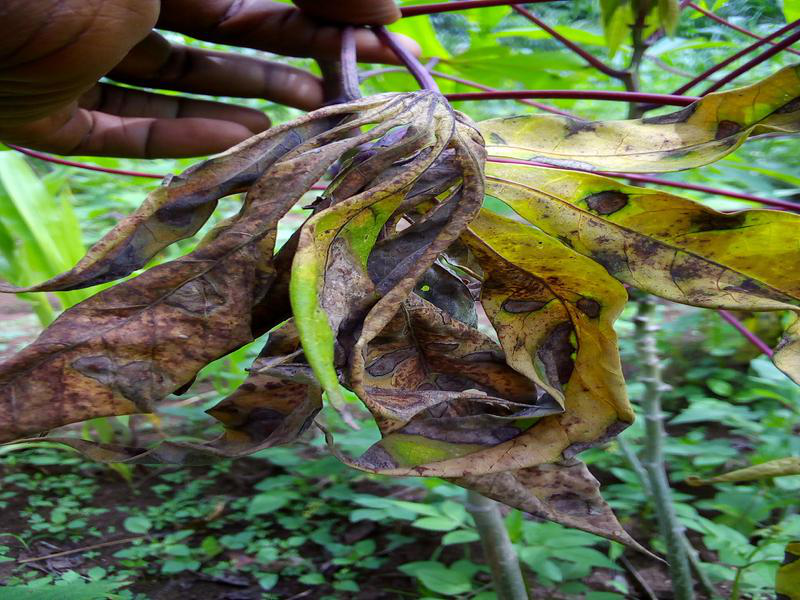

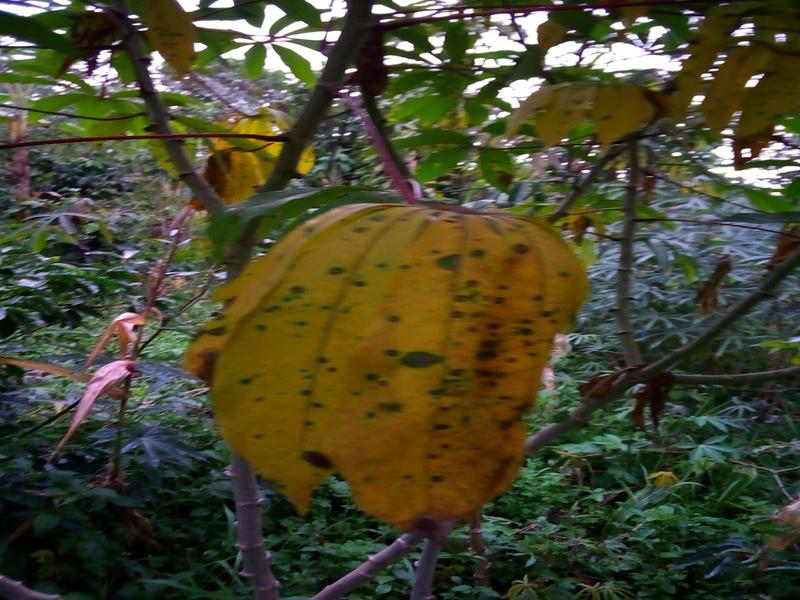

In [13]:
# 檢查資料夾內圖片

roses = list(data_dir.glob('CBB/*'))

for image_path in roses[:2]:
    display.display(Image.open(str(image_path)))

In [14]:
roses[:2]

[PosixPath('/home/u3148947/.keras/datasets/leaf/leaf_labels/CBB/3398825087.jpg'),
 PosixPath('/home/u3148947/.keras/datasets/leaf/leaf_labels/CBB/3548257728.jpg')]

In [15]:
data_dir

PosixPath('/home/u3148947/.keras/datasets/leaf/leaf_labels')

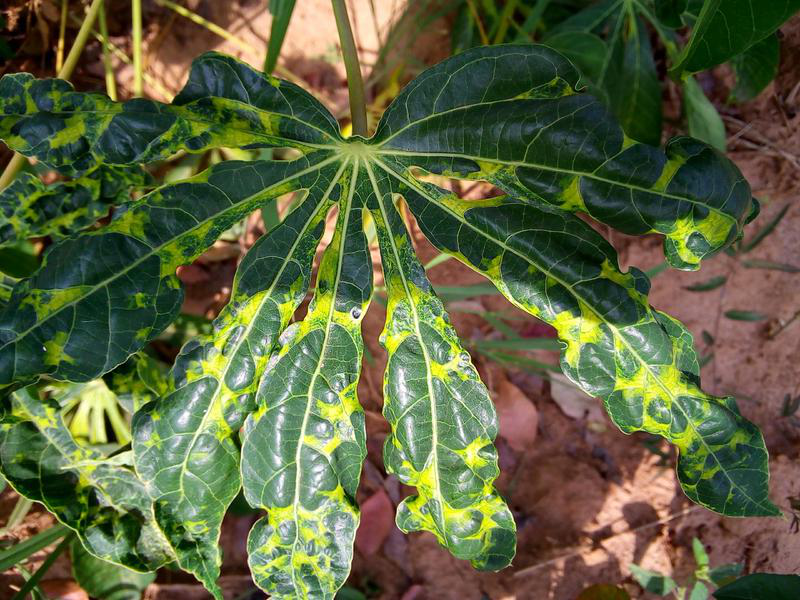

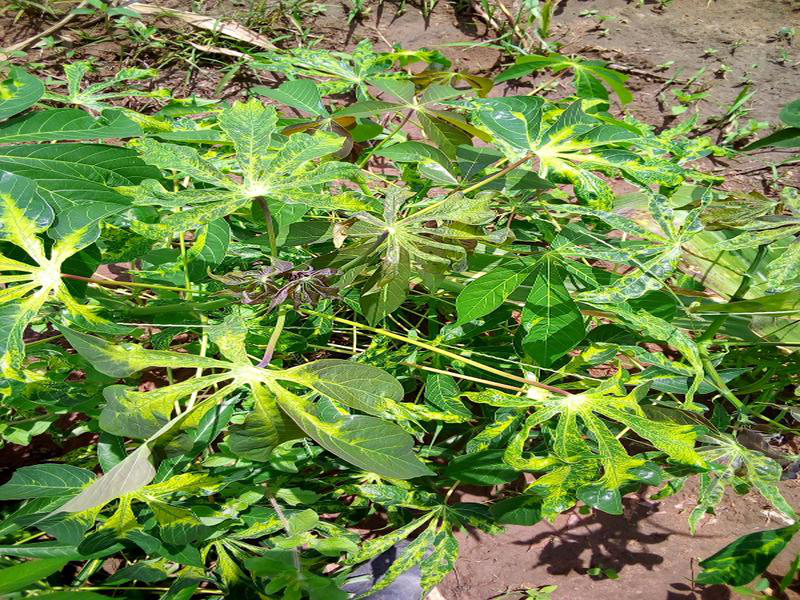

In [16]:
# 檢查資料夾內圖片

roses = list(data_dir.glob('CMD/*'))

for image_path in roses[:2]:
    display.display(Image.open(str(image_path)))

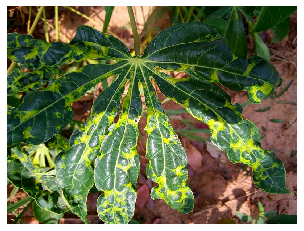

In [17]:
roses = list(data_dir.glob('CMD/*')) # a list of PosixPath object

plt.figure()
for image_path in roses[:1]:
    image = tf.io.read_file(str(image_path))
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.random_saturation(image, 1, 5)
    plt.imshow(image.numpy().astype("uint8"))
    plt.axis("off")

#     display.display(image)

In [18]:
roses[1]

PosixPath('/home/u3148947/.keras/datasets/leaf/leaf_labels/CMD/2687625618.jpg')

## <font color=#Ff1100>Image, batch size</font>

In [19]:
# vars
BATCH_SIZE = 256 #128 #32 
img_height = 224 #512 #224 #100
img_width = 224 #512 #224 #100
# STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

#IMG_SIZE = (224, 224) # IMG_SIZE = (160, 160)

## 2. Load dataset with tf.data


In [20]:
str(data_dir/'*/*')

'/home/u3148947/.keras/datasets/leaf/leaf_labels/*/*'

In [21]:
!ls /home/u3148947/.keras/datasets/leaf/leaf_labels/

CBB  CBSD  CGM	CMD  Healthy


In [22]:
# 以tf.data來讀取資料
# 同樣地，給定本地資料集的路徑。
# 2020-06-11版本(相同)
"""tf.data.Dataset.list_files
Note: The default behavior of this method is to return filenames in 
a non-deterministic random shuffled order. Pass a seed or shuffle=False 
to get results in a deterministic order.預設為random shuffle"""

list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [23]:
# 檢查路徑、檔案

for f in list_ds.take(10):
  print(f.numpy())

b'/home/u3148947/.keras/datasets/leaf/leaf_labels/CBB/2680198267.jpg'
b'/home/u3148947/.keras/datasets/leaf/leaf_labels/CMD/3647655176.jpg'
b'/home/u3148947/.keras/datasets/leaf/leaf_labels/Healthy/1251480782.jpg'
b'/home/u3148947/.keras/datasets/leaf/leaf_labels/CMD/200665366.jpg'
b'/home/u3148947/.keras/datasets/leaf/leaf_labels/CMD/3444851887.jpg'
b'/home/u3148947/.keras/datasets/leaf/leaf_labels/CMD/3807093226.jpg'
b'/home/u3148947/.keras/datasets/leaf/leaf_labels/CBB/3398825087.jpg'
b'/home/u3148947/.keras/datasets/leaf/leaf_labels/CMD/3218166132.jpg'
b'/home/u3148947/.keras/datasets/leaf/leaf_labels/CBB/344993238.jpg'
b'/home/u3148947/.keras/datasets/leaf/leaf_labels/Healthy/3593973663.jpg'


hit: 觀察有無shuffle變化

In [24]:
# 已修改在import cell中

#增加了對類別排序而已sorted ['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']

# class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
# print(class_names)

hit: 這裏可以請同學練習list基本原理與操作，往後資料呈現都會是以多維list or array方式。

hit:列表產生式與產生器的不同，`[] and ()`使用差異。

### Split the dataset into train and validation:

In [25]:
# train 80, val 20
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)



In [26]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

17118
4279


In [27]:
for t,v in zip(train_ds.take(2),val_ds.take(2)):
  print(t.numpy(), '\n')
  print(v.numpy())


b'/home/u3148947/.keras/datasets/leaf/leaf_labels/CBB/1596468225.jpg' 

b'/home/u3148947/.keras/datasets/leaf/leaf_labels/CBB/2680198267.jpg'
b'/home/u3148947/.keras/datasets/leaf/leaf_labels/CMD/1890473397.jpg' 

b'/home/u3148947/.keras/datasets/leaf/leaf_labels/CMD/3647655176.jpg'


In [28]:
#J Save train/val path list for later used

# len(list(val_ds))#1124 images for val_ds

count = 0
for element in val_ds.take(2):
    print(element) #tf.Tensor(b'/home/u3148947/.keras/datasets/uni/ng/CSPAFI#6_19CC2018-05-000_1_NG011_Panel0006_ProcA3_Shot0_V5_D0_Img.jpg', shape=(), dtype=string)
    parts = tf.strings.split(element, os.path.sep)
    print('parts[] =', parts[-2]) # [-2]= dir name, [-1]= file name.
    count += 1   
print(count)
    

tf.Tensor(b'/home/u3148947/.keras/datasets/leaf/leaf_labels/CBB/2680198267.jpg', shape=(), dtype=string)
parts[] = tf.Tensor(b'CBB', shape=(), dtype=string)
tf.Tensor(b'/home/u3148947/.keras/datasets/leaf/leaf_labels/CMD/3647655176.jpg', shape=(), dtype=string)
parts[] = tf.Tensor(b'CMD', shape=(), dtype=string)
2


### Augmentation

#2020-11-30: add image augmentation for Leaf datase to reduce the overfitting.

In [29]:
# data augmentation @cdeotte kernel: https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96
def transform_rotation(image, height, rotation):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = rotation * tf.random.uniform([1],dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape(tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3])

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shear(image, height, shear):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly sheared
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    shear = shear * tf.random.uniform([1],dtype='float32')
    shear = math.pi * shear / 180.
        
    # SHEAR MATRIX
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape(tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3])    

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shear_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

In [30]:
# code source: https://www.kaggle.com/dimitreoliveira/cassava-leaf-disease-tpu-tensorflow-training

CHANNELS = 3
def data_augment(image, label):
    p_rotation = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_shear = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    #2020-11-30:Jadd: already have these.
#     p_brightness = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
#     p_saturation = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    # Brightness
#     if p_brightness > .6:
#         image = tf.image.random_brightness(image, max_delta=0.3)
    # Saturation # not poper for color image
#     if p_saturation > .6:
#         image = tf.image.random_saturation(image, 0.1, 2)
    
    #TEST
#     image = tf.image.rgb_to_grayscale(image) # not work when final reshape.



    
    # Shear
    if p_shear > .2:
        if p_shear > .6:
            image = transform_shear(image, img_height, shear=20.)
        else:
            image = transform_shear(image, img_height, shear=-20.)
            
    # Rotation
    if p_rotation > .2:
        if p_rotation > .6:
            image = transform_rotation(image, img_height, rotation=45.)
        else:
            image = transform_rotation(image, img_height, rotation=-45.)
            
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k=1) # rotate 90º
        
    # Pixel-level transforms
    # TODO:contrast brightness # not poper for color image
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower=.1, upper=1)

    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower=.5, upper=1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta=.3)
        
        
    # Crops
    if p_crop > .7:
        if p_crop > .9:
            image = tf.image.central_crop(image, central_fraction=.6)
        elif p_crop > .8:
            image = tf.image.central_crop(image, central_fraction=.7)
        else:
            image = tf.image.central_crop(image, central_fraction=.8)
    elif p_crop > .4:
        crop_size = tf.random.uniform([], int(img_height*.6), img_height, dtype=tf.int32)
        image = tf.image.random_crop(image, size=[crop_size, crop_size, CHANNELS])
            
    image = tf.image.resize(image, size=[img_height, img_width])

    return image, label


In [31]:
img_height, img_width

(224, 224)

In [32]:
p_rotation = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
p_rotation

<tf.Tensor: shape=(), dtype=float32, numpy=0.3853569>

### Converts a file path to an (img, label) pair:

In [33]:
#J tf2.3新版load_data/images使用one-hot, 所以後面的training 要把sparse_categorical_crossentropy換掉，變傳統的one-hot/categorical loss.
#新版：tf2.3
#
#J modify the get_label for runing at tf2.2 2020-08-06 2020-08-11 OKfortf2.2
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    boolen = parts[-2] == class_names
    #one_hot_num = np.array(boolen, dtype=np.int) not works should use tf.x repalced.
    one_hot_num = tf.dtypes.cast(boolen, tf.int64)
    one_num = tf.argmax(one_hot_num)
    print('one_num:', one_num)
    # Integer encode the label
    return one_num
#     return tf.argmax(one_hot)
#   return tf.math.argmax(one_hot)

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label



# hit: 請學員參考寫註解(英文)的方式，清晰易讀。中文註解主要作為課程說明與程式註解用途不同。

In [34]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds_map = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds_map = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)



one_num: Tensor("ArgMax:0", shape=(), dtype=int64)
one_num: Tensor("ArgMax:0", shape=(), dtype=int64)


In [35]:
for image, label in train_ds_map.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

"""tf2.3
Image shape:  (224, 224, 3)
Label:  2"""

Image shape:  (224, 224, 3)
Label:  0


'tf2.3\nImage shape:  (224, 224, 3)\nLabel:  2'

In [36]:
#sorted ['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']
#sorted ['ng' 'ok']

#get_label('/home/u3148947/.keras/datasets/uni/ng/CSPAFI#4_19CC2018-04-000_3_NG003_Panel0011_ProcA4_Shot0_V28_D0_Img.jpg')
# <tf.Tensor: shape=(), dtype=int64, numpy=0>
get_label('imgs/ng_CSPAFI#4_19CC2018-04-000_3_NG003_Panel0012_ProcA4_Shot0_V11_D0_Img.jpg')

one_num: tf.Tensor(0, shape=(), dtype=int64)


<tf.Tensor: shape=(), dtype=int64, numpy=0>

In [37]:
[img, label] = process_path('imgs/ok_CSPAFI#4_19CC2018-04-000_3_NG005_Panel0009_ProcA3_Shot0_V16_D0_Img.jpg')
print('label =', label)
tf.print(label)

one_num: tf.Tensor(0, shape=(), dtype=int64)
label = tf.Tensor(0, shape=(), dtype=int64)
0


## 3. 使用tf.data訓練模型
### Basic methods for training

To train a model with this dataset you will want the data:

- To be well shuffled.
- To be batched.
- Batches to be available as soon as possible.

These features can be added using the tf.data API. For more details, see the Input Pipeline Performance guide.
https://render.githubusercontent.com/guide/performance/datasets



hit: 基本套路 洗牌 batch 正規化


In [38]:
#J
#新版：簡化很多
# def configure_for_performance(ds):
#   ds = ds.cache()
#   ds = ds.shuffle(buffer_size=1000)
#   ds = ds.batch(BATCH_SIZE)
#   ds = ds.prefetch(buffer_size=AUTOTUNE)
#   return ds



# tf MirroredStrategy seting
strategy = tf.distribute.MirroredStrategy()
REPLICAS = strategy.num_replicas_in_sync
print('\nNumber of REPLICAS: {}\n'.format(REPLICAS))


MULTI_BATCH_SIZE = BATCH_SIZE * strategy.num_replicas_in_sync
print('BATCH_SIZE: {}, MULTI_BATCH_SIZE: {}'.format(BATCH_SIZE, MULTI_BATCH_SIZE))


# def configure_for_performance_cache(ds, cache=True):
#   if cache:
#     if isinstance(cache, str):
#       ds = ds.cache(cache)
#       print("Check cache to file:", cache)
#     else:
#       ds = ds.cache()
#       print("Check cache in memory:", cache)
#   ds = ds.shuffle(buffer_size=image_count) # buffer_size=1000 or buffer_size=image_count
#   ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
#   ds = ds.prefetch(buffer_size=AUTOTUNE)
#   return ds


# 2020-11-30: for augmentation test
def configure_for_performance_cache(ds, cache=True, augment=False):

    
    """#TODO: need to check the parse logic of ds.cache.
    if cache:
        print("Check cache-f1 to file:", cache)
        if isinstance(cache, str):
            ds = ds.cache(cache)
            print("Check cache-f2 to file:", cache)
    else:
        ds = ds.cache()
        print("Check cache in memory:", cache)
    """    
    if cache:
        ds = ds.cache()
        print("Check cache in memory:", cache)
        
    if augment:
        ds = ds.map(data_augment, num_parallel_calls=AUTOTUNE)
        print("Check augment :", augment)
        
    ds = ds.shuffle(buffer_size=image_count) # buffer_size=1000 or buffer_size=image_count
    ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    print("Check ds cache[{}] and augment[{}]".format(cache, augment))
    
    return ds



INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)

Number of REPLICAS: 1

BATCH_SIZE: 256, MULTI_BATCH_SIZE: 256


hit:

    ds.shuffle(buffer_size=1000)
    表示buffer維持一千張圖，隨機抽掉一張後，會由1001張補進維持1K張。因此完美的洗牌建議buffer要大於或等於dataset數量。

In [39]:
%%time
#J 新版：
train_ds_pre = configure_for_performance_cache(train_ds_map, cache=True, augment=True)
val_ds_pre = configure_for_performance_cache(val_ds_map)


Check cache in memory: True
Check augment : True
Check ds cache[True] and augment[True]
Check cache in memory: True
Check ds cache[True] and augment[False]
CPU times: user 987 ms, sys: 872 µs, total: 988 ms
Wall time: 984 ms


### Visualize the data
You can visualize this dataset similarly to the one you created previously.

In [40]:
%%time

#J 新版：tf2.3 
#2020-11-30: to check aug is right for single ds pair: move to above # 檢查資料夾內圖片

# image_batch, label_batch = next(iter(train_ds_pre))



#for image_batch, label_batch in train_ds_pre.repeat().batch(10).take(10):

# for image_batch, label_batch in train_ds_pre.repeat().take(1):
#     print(label_batch)


# plt.figure(figsize=(20, 20))
# for i in range(1):
#   ax = plt.subplot(9, 9, i + 1)
#   plt.imshow(image_batch[i].numpy().astype("uint8"))
#   label = label_batch[i]
# #   print('label from label_batch:', label)
#   plt.title(class_names[label])
#   plt.axis("off")

CPU times: user 7 µs, sys: 4 µs, total: 11 µs
Wall time: 20.5 µs


CPU times: user 2min 56s, sys: 59.5 s, total: 3min 56s
Wall time: 1min 3s


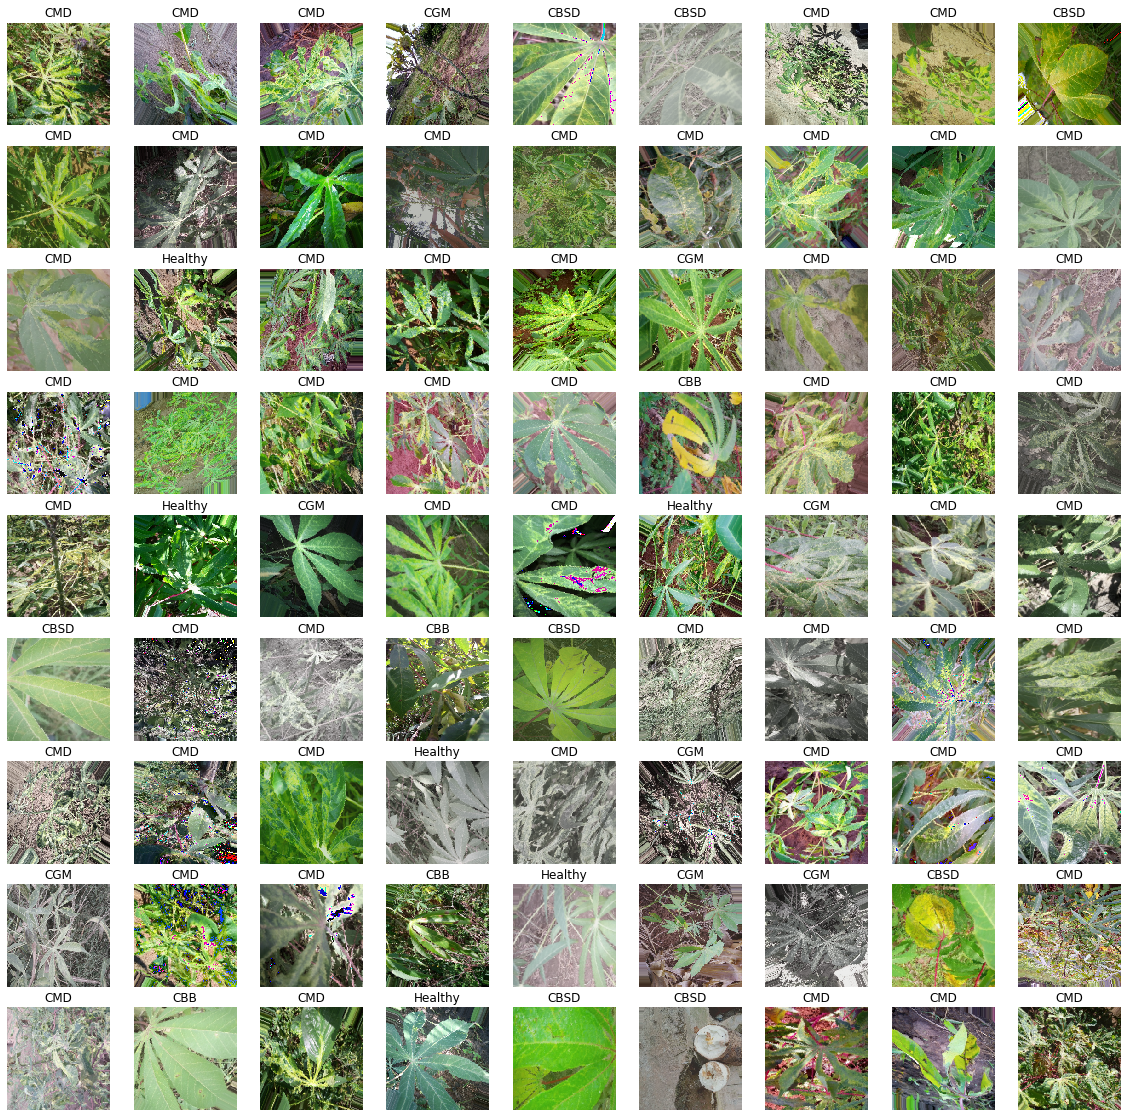

In [41]:
%%time

#J 新版：tf2.3

image_batch, label_batch = next(iter(train_ds_pre))

plt.figure(figsize=(20, 20))
for i in range(81):
  ax = plt.subplot(9, 9, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
#   print('label from label_batch:', label)
  plt.title(class_names[label])
  plt.axis("off")

In [42]:
#====================================================================================================#

In [43]:
#====================================================================================================#

In [44]:
#====================================================================================================#

In [45]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [46]:
tf.config.experimental.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [47]:
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 1


In [ ]:
#====================================================================================================#

In [ ]:
#====================================================================================================#

## Multi GPUs model : Only Top Layer (Transfer Learning)

tf.distribute.MirroredStrategy()

In [ ]:
#strategy => move to tf.data session for check gloable batch size.

model_name = 'MobileNet' #'Xception' 'InceptionV3' "ResNet50" #'EfficientNetB7' for tf2.3

IMG_SHAPE = (img_height, img_width) + (3,)

base_learning_rate = 0.0001 # org. 0.0001 = 1e-4

num_classes = len(class_names)


with strategy.scope():
    
    base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                                   include_top=False,
                                                   weights='imagenet')
    # Freeze the base_model
    base_model.trainable = False
    
    # FIXIT in future. added fake inputs for let BN works.
    inputs = tf.keras.Input(shape=(IMG_SHAPE))
    bm_output = base_model(inputs, training=False)
    
    gap2d = tf.keras.layers.GlobalAveragePooling2D()(bm_output)
    dropout = tf.keras.layers.Dropout(0.2)(gap2d)#J add dropout
    outputs = tf.keras.layers.Dense(num_classes)(dropout)

    model = tf.keras.Model(inputs, outputs, name=model_name)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    

In [ ]:
len(model.trainable_variables)

In [ ]:
model.name

In [ ]:
# Let's take a look at the base model architecture
model.summary()

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

In [ ]:
%%time
initial_epochs = 500
history = model.fit(train_ds_pre,
                    epochs=initial_epochs,
                    validation_data=val_ds_pre,
                   callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10), tensorboard_callback])

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

fig = plt.figure(figsize=(8, 8), num=model_name)
fig.suptitle(model_name + ' (top layer)', fontsize=14, fontweight='bold')
print("base model and training pahse: {}".format(model_name + '_top-layer' + '_lr' + str(base_learning_rate) + '_e' + str(initial_epochs) ))


plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like tf.keras.layers.BatchNormalization and tf.keras.layers.Dropout affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## <font color=#FF6600>Multi GPUs model : Top-100 Layers (Fine tuning ONLY without transfer learning.) </font>


tf.distribute.MirroredStrategy() Fine tuning

### Un-freeze the top layers of the model

In [48]:
#strategy => move to tf.data session for check gloable batch size.

model_name = 'MobileNet'
#'MobileNet' 'Xception' 'InceptionV3' "ResNet50" #'EfficientNetB0''EfficientNetB7' for tf2.3 EfficientNetB7

IMG_SHAPE = (img_height, img_width) + (3,)

base_learning_rate = 0.0001 # org. 0.0001 = 1e-4 #改成程序化依epoch減少lr即可，沒有先做transfer leaning的必要.
# lr = 1e-6
lr=base_learning_rate#/1000
print("lr_base = {:.12f}\nlr_tune = {:.12f}\n".format(base_learning_rate, lr))


num_classes = len(class_names)

# Fine-tune from this layer onwards
fine_tune_at = 50 # this is LAYER position NOT epoch!!!


with strategy.scope():
    
    base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,# efnet donot need input_layer
                                                   include_top=False,
                                                   weights='imagenet')
    # Un-freeze the top layers of the model
    base_model.trainable = True
    
    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
      layer.trainable = False

    
    # FIXIT in future. added fake inputs for let BN works.
#     inputs = tf.keras.Input(shape=(IMG_SHAPE))
#     bm_output = base_model(inputs, training=False)


    # FIXIT in future. added fake inputs for let BN works. (Did we fix it??)(workable but broken graph!!! can not load in TB or tf-explain!!)
    bm_output = base_model(base_model.input, training=False)
    
    
    gap2d = tf.keras.layers.GlobalAveragePooling2D()(bm_output)#(base_model.output)
    dropout = tf.keras.layers.Dropout(0.2)(gap2d)#J add dropout, 0.2 is ok.
    outputs = tf.keras.layers.Dense(num_classes)(dropout)

    model = tf.keras.Model(base_model.input, outputs, name=model_name)

# The transfer learning setup
#     model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
#               loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

# The fine tune and multi-GPUs and LearningRateScheduler setup
    model.compile(optimizer = tf.keras.optimizers.RMSprop(),# adm -> RMSprop??, original is /10 may to /100 to reduce the overfitting
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),              
              metrics=['accuracy'])

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# NOT-trainable layers
l_c = 0
for layer in base_model.layers[:fine_tune_at]:
  l_c += 1
print("Number of NOT-trainable layers: ", l_c)

# trainable layers
print("Number of trainable layers: ", len(base_model.layers) - l_c)

lr_base = 0.000100000000
lr_tune = 0.000100000000

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/rep

In [49]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [50]:
# Let's take a look at the base model architecture
model.summary()

Model: "MobileNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 5125      
Total params: 3,233,989
Trainable params: 2,674,181
Non-trainable params: 559,808
_________________________________________________________________


In [51]:
# Function for decaying the learning rate.
# You can define any decay function you need.

# simple step decay
# def decay(epoch):
#   if epoch < 100:
#     return 1e-3
#   elif epoch >= 100 and epoch < 200:
#     return 1e-4
#   elif epoch >= 200 and epoch < 300:
#     return 1e-5
#   elif epoch >= 300 and epoch < 400:
#     return 1e-6
#   else:
#     return 1e-7

# # exponential decay
# def decay(epoch):
#    k = 0.05
#    t = epoch * 0.02
#    lrate = base_learning_rate * np.exp(-k*t) # t is iteration number.

#    #tf.summary.scalar('learning rate', data=lrate, step=epoch)# for tb plot.
#    return lrate


# step decay
def decay(epoch):
   initial_lrate = base_learning_rate
   drop = 0.5 #0.8
   epochs_drop = 50 #10.0
   lrate = initial_lrate * tf.math.pow(drop, tf.math.floor((1+epoch)/epochs_drop))
#    #tf.summary.scalar('learning rate', data=lrate, step=epoch)# for tb plot.
   return lrate


LR decay curve
e0    lr: tf.Tensor(1e-04, shape=(), dtype=float32)
e100  lr: tf.Tensor(2.5e-05, shape=(), dtype=float32)
e500  lr: tf.Tensor(9.765625e-08, shape=(), dtype=float32)
e1000 lr: tf.Tensor(9.536743e-11, shape=(), dtype=float32)
e2000 lr: tf.Tensor(9.094948e-17, shape=(), dtype=float32)


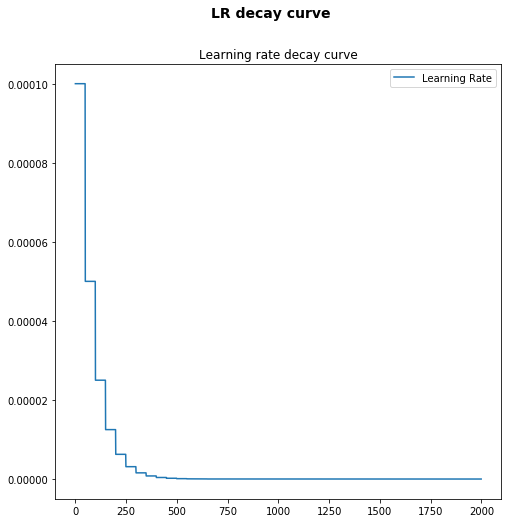

In [52]:
fig = plt.figure(figsize=(8, 8), num=model_name)
fig.suptitle("LR decay curve", fontsize=14, fontweight='bold')
print("LR decay curve")

num_epoch = range(2000)
num_lr = []
for epoch in range(2000):
    num_lr.append(decay(epoch))
#     print(decay(epoch))

plt.plot(num_epoch, num_lr, label='Learning Rate')
# plt.ylim([0.000000000001, 1])
plt.legend(loc='upper right')
plt.title('Learning rate decay curve')

print("e0    lr:", num_lr[0])
print("e100  lr:", num_lr[100])
print("e500  lr:", num_lr[500])
print("e1000 lr:", num_lr[1000])
print("e2000 lr:", num_lr[2000 - 1])

2000 total epochs and 83 steps per epoch
Learning rate schedule: 1e-08 to 0.0001 to 1e-08


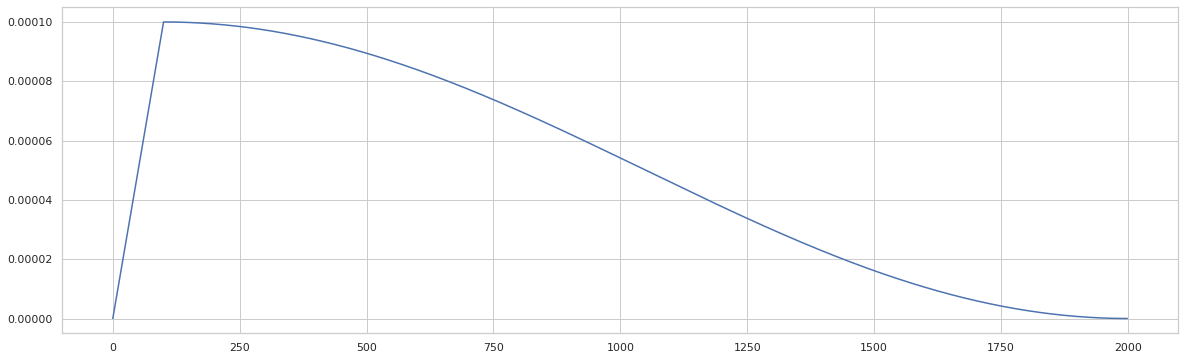

In [53]:
# Function for decaying the learning rate.
# You can define any decay function you need.

LEARNING_RATE = 1e-4 * REPLICAS

#for test
EPOCHS = 2000
NUM_TRAINING_IMAGES = image_count


LR_START = 1e-8
LR_MIN = 1e-8
LR_MAX = LEARNING_RATE
LR_RAMPUP_EPOCHS = 100
LR_SUSTAIN_EPOCHS = 0
N_CYCLES = .5


def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        progress = (epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) / (EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)
        lr = LR_MAX * (0.5 * (1.0 + tf.math.cos(math.pi * N_CYCLES * 2.0 * progress)))
        if LR_MIN is not None:
            lr = tf.math.maximum(LR_MIN, lr)
            
    return lr

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]

sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

print(f'{EPOCHS} total epochs and {NUM_TRAINING_IMAGES//BATCH_SIZE} steps per epoch')
print(f'Learning rate schedule: {y[0]:.3g} to {max(y):.3g} to {y[-1]:.3g}')

In [54]:
# Callback for printing the LR at the end of each epoch.
class PrintLR(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
                                                      model.optimizer.lr.numpy()))

In [55]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S") + "_" + model_name

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

#self lr save
# file_writer = tf.summary.create_file_writer(logdir + "/metrics")
# file_writer.set_as_default()


In [56]:
callbacks = [
#     tf.keras.callbacks.TensorBoard(log_dir='./logs'),
#     tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
#                                        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20), #monitor='loss' or monitor='val_loss', stop after 20 epoch no improve.
    tf.keras.callbacks.LearningRateScheduler(decay),#,decay or lrfn or..
#     PrintLR(),
    tensorboard_callback
]

In [57]:
len(model.trainable_variables)

38

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [58]:
%%time
fine_tune_epochs = 2000
total_epochs =  fine_tune_epochs #initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds_pre,
                         epochs=total_epochs,
                         #initial_epoch=history.epoch[-1],
                         validation_data=val_ds_pre,
                         callbacks=callbacks)

Epoch 1/2000
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
 1/67 [..............................] - ETA: 0s - loss: 2.2378 - accuracy: 0.0859WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
67/67 [==============================] - 39s 580ms/step - loss: 1.3028 - accuracy: 0.5816 - val_loss: 1.1622 - val_accuracy: 0.6097
Epoch 2/2000
67/67 [==============================] - 12s 175ms/step - loss: 1.1647 - accuracy: 0.6109 - val_loss: 1.2328 - val_accuracy: 0.6097
Epoch 3/2000
67/67 [==============================] - 23s 341ms/step - loss: 1.1308 - accuracy: 0.6172 - val_loss: 1.0601 - val_accuracy: 0.6251
Epoch 4/2000
67/67 [==============================] - 11s 171ms/step - loss: 1.1156 - accuracy: 0.6210 - val_loss: 1.1657 -

In [59]:
# Returns the model's display labels for all outputs.
model.metrics_names

['loss', 'accuracy']

In [60]:
# for only fine tune
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

base model and training pahse: MobileNet_top-100layer_lr0.0001_e2000


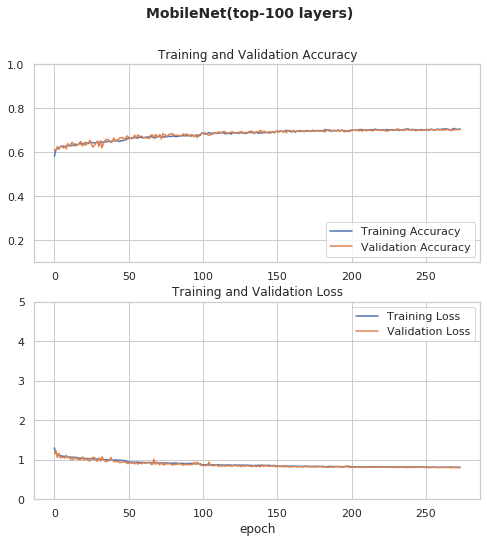

In [61]:
# for only fine tune
fig = plt.figure(figsize=(8, 8), num=model_name)
fig.suptitle(model_name + '(top-100 layers)', fontsize=14, fontweight='bold')
print("base model and training pahse: {}".format(model_name + '_top-100layer' + '_lr' + str(lr) + '_e' + str(total_epochs) ))


plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.1, 1])
# plt.plot([initial_epochs-1,initial_epochs-1],
#           plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 5.0])
# plt.plot([initial_epochs-1,initial_epochs-1],
#          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [62]:
# # Load the TensorBoard notebook extension  
# %load_ext tensorboard

# %tensorboard --logdir logs/scalars --host=203.145.219.191 --port=5000

"""The above method would not work in TWCC due to the port lock.

公用 IP: 203.145.219.191
目標埠: 5000 (userdefine1)
對外埠: 50197 (public port)

A.
1. open a terminals:$tensorboard --logdir logs/scalars --port=5000 --bind_all
2. open a browser: http://203.145.219.191:50197/

ps.Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all

B.

"""

'The above method would not work in TWCC due to the port lock.\n\n公用 IP: 203.145.219.191\n目標埠: 5000 (userdefine1)\n對外埠: 50197 (public port)\n\nA.\n1. open a terminals:$tensorboard --logdir logs/scalars --port=5000 --bind_all\n2. open a browser: http://203.145.219.191:50197/\n\nps.Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all\n\nB.\n\n'

In [ ]:
# for tf + ft

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
fig = plt.figure(figsize=(8, 8), num=model_name)
fig.suptitle(model_name + '(top-100 layers)', fontsize=14, fontweight='bold')
print("base model and training pahse: {}".format(model_name + '_top-100layer' + '_lr' + str(lr) + '_e' + str(total_epochs) ))


plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.1, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Save model with full name


In [ ]:
#Saving a Keras model:
# today_date = datetime.today().strftime('%Y-%m-%d-%H-%M')
# final_training_acc = str(round(history_fine.history['accuracy'][-1], 4))

# current_model_name = dataset_name + '_' + model_name + '_top'+ str(fine_tune_at) + '_' + 'bs' + str(BATCH_SIZE) + '_w' + str(img_width) + 'h' + str(img_height) + '_e' + str(fine_tune_epochs) + '_acc' + final_training_acc + '_' + today_date + '.h5'
# current_model_name = 'leaf-2020-11-29-EfficientNetB0_top-layer800_lr_fun_acc.7378_wh224.h5'
# current_model_name = 'leaf-2020-11-30-MobileNetv1_top-layer50_lr_decay_acc.6936_wh224.h5'
current_model_name = 'leaf-2020-11-30-MobileNetv1_top-layer50_lr_decay_acc.xxx_wh224_exxx.h5'


model.save(current_model_name)
print("Save model: ", current_model_name)

In [ ]:
#====================================================================================================#

### Load pre-trained model

In [ ]:
#Loading the model back:
# current_model_name = 'uni_Xception_top100_bs64_w100h100_e200_acc0.9108_2020-09-19-15-12.h5'
current_model_name = 'leaf-2020-11-28-MobileNetv1_top-layer_lr_exxx_acc.xxx_wh224.h5'
model_back = tf.keras.models.load_model(current_model_name)

In [ ]:
%%time
loss, accuracy = model_back.evaluate(val_ds_pre)
print('Test accuracy :', accuracy)

print("count roughly ds size: ", tf.data.experimental.cardinality(val_ds_pre).numpy() * BATCH_SIZE)

### <font color=#1267e6>'It seems that different shuffle makes validation accuracy varies.'</font>

We believe that the dataset may not have general distribution. According to each shuffle, make a different outcome. It seems that different shuffle makes validation accuracy varies.

In [ ]:
'Restart and Ruan All'

36/36 [==============================] - 0s 12ms/step - loss: 0.2655 - accuracy: 0.8932
roughly ds size:  1152
CPU times: user 425 ms, sys: 70.8 ms, total: 496 ms
Wall time: 485 ms

36/36 [==============================] - 1s 25ms/step - loss: 0.2461 - accuracy: 0.9039
roughly ds size:  1152
CPU times: user 4.73 s, sys: 1.36 s, total: 6.09 s
Wall time: 6.73 s

36/36 [==============================] - 1s 25ms/step - loss: 0.2514 - accuracy: 0.9021
roughly ds size:  1152
CPU times: user 4.87 s, sys: 1.48 s, total: 6.35 s
Wall time: 6.99 s

'It seems that different shuffle makes validation accuracy varies.'

In [ ]:
#====================================================================================================#

In [ ]:
#====================================================================================================#

In [ ]:
#====================================================================================================#

In [ ]:
#====================================================================================================#

## Evaluation and prediction

Finaly you can verify the performance of the model on new data using test set.

沒有另外製作test data，改用val測試

In [ ]:
%%time
test_dataset = val_ds_pre
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

In [ ]:
# image_batch, label_batch = val_ds_pre.take(1) ???? 

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch) #J removed the (image_batch) of xx_batch(image_batch).flatten()
                                                  #J then, softmax/sigmoid is same, and key is argmax(L,1)

# Apply a sigmoid since our model returns logits
# predictions = tf.nn.sigmoid(predictions)
predictions = tf.nn.softmax(predictions)#J try to fix the logts not correct?! but not works/
predictions = tf.where(predictions < 0.5, 0, 1) #J if less then 0.5 set to 0, else set to 1.
predictions = tf.argmax(predictions, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(30):
  ax = plt.subplot(6, 6, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))

  #org method
#   plt.title(class_names[predictions[i]])
    
  #J C method
  if predictions[i] == label_batch[i]:
      plt.title(class_names[predictions[i]])
  else:
      plt.title(class_names[predictions[i]],fontweight='bold', color='red')

  #J pythonic method 1
#   color = "green" if predictions[i] == label_batch[i] else "red"
#   plt.title(class_names[predictions[i]], color=color)

  #J pythonic method 2
#   plt.title(class_names[predictions[i]], color=("green" if predictions[i] == label_batch[i] else "red"))

  plt.axis("off")

In [ ]:
#====================================================================================================#

### Save model


In [ ]:
#Saving a Keras model:
# current_model_name = 'test-tf22-Xception_top-100layer_lr0.0001decay_do0.4_e404_20200916.h5'
# model.save(current_model_name)

### Load model and inference

In [ ]:
#Loading the model back:
model_back = tf.keras.models.load_model(current_model_name)

In [ ]:
#test load back model
model = model_back

# sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
# #sunflower_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/4/40/Sunflower_sky_backdrop.jpg/1024px-Sunflower_sky_backdrop.jpg"
# sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

# img = tf.keras.preprocessing.image.load_img(
#     sunflower_path, target_size=(img_height, img_width)
# )


# ngok_path = "imgs/ng_CSPAFI#4_19CC2018-04-000_3_NG003_Panel0012_ProcA4_Shot0_V11_D0_Img.jpg"
# ngok_path = 'imgs/ok_CSPAFI#4_19CC2018-04-000_3_NG005_Panel0009_ProcA3_Shot0_V16_D0_Img.jpg'

# ngok_path = '/home/u3148947/.keras/datasets/leaf/leaf_labels/CBB/3548257728.jpg'
# ngok_path = '/home/u3148947/.keras/datasets/leaf/leaf_labels/CBB/3398825087.jpg'

ngok_path = '/home/u3148947/.keras/datasets/leaf/leaf_labels/CMD/1000812911.jpg'

img = tf.keras.preprocessing.image.load_img(
    ngok_path, target_size=(img_height, img_width)
)


img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [ ]:
tf.print(score)
# confidence of two classes
# [9.06327458e-09 1]

In [ ]:
"""Downloading data from https://upload.wikimedia.org/wikipedia/commons/thumb/4/40/Sunflower_sky_backdrop.jpg/1024px-Sunflower_sky_backdrop.jpg
262144/261558 [==============================] - 1s 3us/step
This image most likely belongs to sunflowers with a 61.29 percent confidence."""

# 上面寫法會永遠保留第一次下載的影像，並且cache在.keras/datasets/Red_sunflower
# 因此，要使用新的影像做測試，需要刪除原本的檔案即可
!rm -rf ~/.keras/datasets/Red_sunflower

In [ ]:
#model.summary()

In [ ]:
#====================================================================================================#

In [ ]:
#====================================================================================================#

In [ ]:
#====================================================================================================#

In [ ]:
#====================================================================================================#

### tf.explan

#### 貌似跟模型有關，完整模型NN-Interpretability-tf2.ipynb(with TF2.2)是ＯＫ的 所以也有可能是tf版本問題

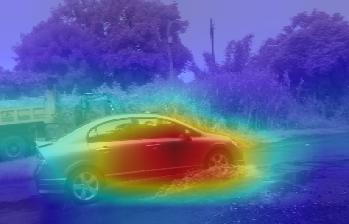

#### 2020-08-08 TF version PROBLEM!!!
* tf-explain can not run with tf2.3 but tf2.2 is fine.
* tf.data one-hot/argmax work with tf2.3 but NOT tf2.2.
* 
* workaround: (1)create tf.data in tf2.3, (2)train model in tf2.2 or 2.3, (3)then tf-explain in tf2.2!

In [ ]:
#J tf-explain 對subgraph的模型無法處理，需要讀入後重新編成序列是模型
""" ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_1_5:0", 
shape=(None, 224, 224, 3), dtype=float32) at layer "input_1". The following previous 
layers were accessed without issue: []

https://github.com/sicara/tf-explain/issues/138

略有不同，
ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_37:0", 
shape=(None, 224, 224, 3), dtype=float32) at layer "input_37". The following previous 
layers were accessed without issue: []
變成是mbv2本身第一層輸入無法連結，而不是外加的輸入處理。換模型測試避開mb特殊外加做法。

"""

model = tf.keras.models.load_model(current_model_name)
# model.summary()

In [ ]:
#!pip3 install tf-explain

In [ ]:
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity
from tf_explain.core.grad_cam import GradCAM
from tf_explain.core.smoothgrad import SmoothGrad
from tf_explain.core.vanilla_gradients import VanillaGradients
from tf_explain.core.integrated_gradients import IntegratedGradients
# SmoothGrad, VanillaGradients cannot use lauer_anme


In [ ]:
#增加了對類別排序而已sorted ['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']
# 0,1,2,3,4

#tf-explain parameters
IMAGE_PATH = '/home/u3148947/.keras/datasets/uni/ok/CSPAFI#4_19CC2018-04-000_3_NG005_Panel0009_ProcA3_Shot0_V16_D0_Img.jpg'#'./Red_sunflower.jpg'#'./0_in.jpg' # 37.jpg, 0_in.jpg, cat.jpg
LAYER_NAME = 'conv5_block3_out' #J if non given default is last 4D layer of model
# LAYER_NAME = None

# Load pretrained model or your own
# model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=True) # .vgg16.VGG16 -> resnet50.ResNet50

#Loading the model back:
model = tf.keras.models.load_model(current_model_name)


#In memory model: just do not thing!
# model = in-memory-Model
#In memory model: just do not thing!


# Load a sample image (or multiple ones)
img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)
data = ([img], None)


# Start explainer

# explainer = OcclusionSensitivity()
# grid = explainer.explain(validation_data=data, model=model, patch_size=4, class_index=3) 


explainer = GradCAM()
grid = explainer.explain(data, model, colormap=cv2.COLORMAP_JET, image_weight=0.5, class_index=0)  # 281 is the tabby cat index in ImageNet

# explainer = GradCAM()
# grid = explainer.explain(validation_data=data, model=model, layer_name=LAYER_NAME, class_index=3)  # 281 is the tabby cat index in ImageNet

# explainer = SmoothGrad()
# grid = explainer.explain(validation_data=data, model=model, class_index=1)

# explainer = IntegratedGradients()
# grid = explainer.explain(validation_data=data, model=model, class_index=281) 
#479: 'car wheel',


#J 
#Save CAM image
out_name = 'tf-explain_GCAM_' + LAYER_NAME + '.png'
explainer.save(grid, ".", out_name)

#Show it now
import ipyplot
img_org = cv2.imread(IMAGE_PATH)
img_org = cv2.resize(img_org, (224, 224), interpolation=cv2.INTER_CUBIC)
img_org = cv2.cvtColor(img_org, cv2.COLOR_BGR2RGB)

# img_cam = cv2.cvtColor(grid, cv2.COLOR_BGR2RGB)
img_cam = cv2.cvtColor(grid, cv2.COLOR_RGB2BGR)

ipyplot.plot_images([img_org, img_cam],['image', 'feature'], max_images=20, img_width=250)

## copy A. Grad CAM with raw Implementation

In [ ]:
import cv2
import numpy as np
import tensorflow as tf

IMAGE_PATH = '/home/u3148947/.keras/datasets/uni/ok/CSPAFI#4_19CC2018-04-000_3_NG005_Panel0009_ProcA3_Shot0_V16_D0_Img.jpg'#'./Red_sunflower.jpg'#'./0_in.jpg' # 37.jpg, 0_in.jpg, cat.jpg
#'./Red_sunflower.jpg'#'./0_in.jpg' # 37.jpg, 0_in.jpg, cat.jpg
LAYER_NAME = 'conv5_block3_out' # vgg16's block5_conv3 -> resnet50's conv5_block3_out

""" imagenet1000_clsidx_to_labels.txt

https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

281: 'tabby, tabby cat',
479: 'car wheel',

"""
CAM_CLASS_INDEX = 0 #479 #281 # CCI

img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)

#org
# model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=True) # .vgg16.VGG16 -> resnet50.ResNet50

#Loading the model back:
model = tf.keras.models.load_model(current_model_name)


grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAYER_NAME).output, model.output])

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(np.array([img]))
    loss = predictions[:, CAM_CLASS_INDEX]

output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]

gate_f = tf.cast(output > 0, 'float32')
gate_r = tf.cast(grads > 0, 'float32')
guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

weights = tf.reduce_mean(guided_grads, axis=(0, 1))

cam = np.ones(output.shape[0: 2], dtype = np.float32)

for i, w in enumerate(weights):
    cam += w * output[:, :, i]

cam = cv2.resize(cam.numpy(), (224, 224))
cam = np.maximum(cam, 0)
heatmap = (cam - cam.min()) / (cam.max() - cam.min())

cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

# output_image = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.6, cam, 0.4, 0)# change original image color.
output_image = cv2.addWeighted(img.astype('uint8'), 0.6, cam, 0.4, 0)

#Save CAM image
out_name = IMAGE_PATH + '_GCAM_' + LAYER_NAME + '_CCI-' + str(CAM_CLASS_INDEX) + '.png'
cv2.imwrite(out_name, output_image) # OK with RGB format

#Show it now
plt.imshow(output_image)
plt.title(out_name)
plt.show()

#Show it now
import ipyplot
img_org = cv2.imread(IMAGE_PATH)
img_org = cv2.resize(img_org, (224, 224), interpolation=cv2.INTER_CUBIC)
img_org = cv2.cvtColor(img_org, cv2.COLOR_BGR2RGB)
img_cam = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
# img_cam = output_image


ipyplot.plot_images([img_org, img_cam],['image', 'active'], max_images=20, img_width=224)
print("CAM for ID:", CAM_CLASS_INDEX)
print("class_names: 0 ,1 , 2 \n",  class_names)

# #J refunction this

In [ ]:
import cv2
import numpy as np
import tensorflow as tf

def GCAM(model, IMAGE_PATH, LAYER_NAME, img, CAM_CLASS_INDEX):

    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAYER_NAME).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.array([img]))
        loss = predictions[:, CAM_CLASS_INDEX]

    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')
    guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    cam = np.ones(output.shape[0: 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam.numpy(), (224, 224))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

    # output_image = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.6, cam, 0.4, 0)# change original image color.
    output_image = cv2.addWeighted(img.astype('uint8'), 0.6, cam, 0.4, 0)

    #Save CAM image
    out_name = IMAGE_PATH + '_GCAM_' + LAYER_NAME + '_CCI-' + str(CAM_CLASS_INDEX) + '.jpg'
    cv2.imwrite(out_name, output_image) # OK with RGB format
    print("Save CAM to:", out_name)


    #return result image
    return cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)#output_image #somehow cv2 issue


In [ ]:
model = tf.keras.models.load_model(current_model_name)

IMAGE_PATH = 'imgs/ok_CSPAFI#4_19CC2018-04-000_3_NG005_Panel0009_ProcA3_Shot0_V16_D0_Img.jpg'#'./Red_sunflower.jpg'#'./0_in.jpg' # 37.jpg, 0_in.jpg, cat.jpg
LAYER_NAME = 'conv5_block3_out' # vgg16's block5_conv3 -> resnet50's conv5_block3_out
img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)
# CAM_CLASS_INDEX = 2 #479 #281 # CCI

p = []
for i in range(num_classes):
    tempimg = GCAM(model,IMAGE_PATH,LAYER_NAME,img,CAM_CLASS_INDEX=i)
    p.append(tempimg)

ipyplot.plot_images([img.astype('uint8'), p[0], p[1]],['image', 'activeID-0', 'activeID-1', 'activeID-2'], max_images=20, img_width=224)
# print("CAM for ID:", CAM_CLASS_INDEX)
print("[CAM for each class name]")
print("class_names: 0 ,1 \n",  class_names)
print(type(p), np.array(p).shape)

In [ ]:
%%time

imgs_dir = pathlib.Path('okng/ng/')
imgs_list = list(imgs_dir.glob('*.jpg'))

model = tf.keras.models.load_model(current_model_name)
LAYER_NAME = 'conv5_block3_out' # vgg16's block5_conv3 -> resnet50's conv5_block3_out
CAM_CLASS_INDEX = 2 #479 #281 # CCI

p = []
for ip in imgs_list:
    print(ip)  
    IMAGE_PATH = str(ip)
    img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))
    img = tf.keras.preprocessing.image.img_to_array(img)
    
    for i in range(num_classes):
        tempimg = GCAM(model,IMAGE_PATH,LAYER_NAME,img,CAM_CLASS_INDEX=i)
        p.append(tempimg)

        
#TODO
# all_cam = [[GCAM(model,LAYER_NAME,img,CAM_CLASS_INDEX=i)] for i in range(num_classes) for path in imgs_list]



In [ ]:
('okng/ok/')
Wall time: 33min 42s
('okng/ng/')
Wall time: 45min 22s

### Performance

Note: This section just shows a couple of easy tricks that may help performance. For an in depth guide see Input Pipeline Performance.

To investigate, first here's a function to check the performance of our datasets:

In [ ]:
import time
default_timeit_steps = 100 #1000

def timeit(ds, steps=default_timeit_steps):
  start = time.time()
  it = iter(ds)
  for i in range(steps):
    batch = next(it)
    if i%10 == 0:
      print('.',end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))


Let's compare the speed of the two data generators:

In [ ]:
# `keras.preprocessing`
timeit(train_data_gen)


In [ ]:
# `tf.data`
timeit(train_ds)

A large part of the performance gain comes from the use of .cache.

In [ ]:
uncached_ds = prepare_for_training(labeled_ds, cache=False)
timeit(uncached_ds)


If the dataset doesn't fit in memory use a cache file to maintain some of the advantages:


In [ ]:
filecache_ds = prepare_for_training(labeled_ds, cache="./flowers.tfcache")
timeit(filecache_ds)

# 第一次cache會比較慢

In [ ]:
!ls -lh

In [ ]:
!ls -lh ~/.keras/dataset

In [ ]:
!ls -lah ~/.keras/datasets

In [ ]:
!du -sh ~/.keras/datasets/flower_photos

hit: 2.1G tf.data. cache的檔案似乎是原始檔案的九倍大。

## Reference:


* https://www.tensorflow.org/tutorials/load_data/tfrecord [如何製作TFRecord檔案/實作1]的原始碼與教學

* https://www.tensorflow.org/tutorials/load_data/images [實作2 flowers dataet] 主要原始碼
* https://www.tensorflow.org/guide/data [實作2 flowers dataet] 參考Create the image.ImageDataGenerator演示，但此演示較簡略僅參考未使用在本教學中
* http://medium.com/@lufor129/tensorflow-圖片數據增強-一-tfrecord-轉換-bd51a70277c  [實作2]的原始碼
* https://dotblogs.com.tw/shaynling/2017/11/20/150241 【Python】TensorFlow學習筆記(二)：初探 TFRecord 夏恩 [實作2]的原始碼


** 注意：如果是在有conda環境下，請注意啟動的環境是否正確。目前twcc+cntr+anaconda+base env.時，由於bashrc path直接導入base環境的pytroch，造成原有系統的tensorflow搜尋不到。請修改bashrc中的path路徑，或是根本上不要在base上安裝，要新建mytrochenv來分離安裝。

# temp for Confusion

In [ ]:
#Check is the accuracy same as fininal val of training pahse
model_back = model
loss, accuracy = model_back.evaluate(val_ds_pre)
print('Test accuracy :', accuracy)

### Check prediction 1v2 : from tf.dataset  with Batch images

In [ ]:
%%time
# rewrite to prediction with batch of ds, replace the list of file to speed up.
# todo: Checked right!:model_back.predict_on_batch [OK done 20200904]

batch_n = 0
acc_count= 0

label_true_all = []
label_pred_all = []

for image_batch, label_batch in val_ds_pre: #ds set to repeat forever
    batch_n += 1
    pred_max = []
    pred = model_back.predict_on_batch(image_batch)
    
    label_batch_np = label_batch.numpy()
    label_true_all.extend(label_batch_np)
    print('label_batch_np = ',label_batch_np)
    
    for i in range(MULTI_BATCH_SIZE):#BATCH_SIZE to MULTI_BATCH_SIZE if used Multi-GPU training
#         print(i)
        try:
            score = tf.nn.softmax(pred[i])
            label_pred = np.argmax(score)
            pred_max.append(label_pred)
            
#             print('label_batch_np[i] = ', label_batch_np[i])
            
            if label_batch_np[i] == label_pred:
                acc_count += 1
        except IndexError:
            print("End of batch")
    label_pred_all.extend(pred_max)
    
    print("pred =", pred_max)
print("acc_count =", acc_count, "  (if score == label[i] then count one.)") 
print("Number of batch used = ",batch_n)


In [ ]:
len(label_true_all)

In [ ]:
len(label_pred_all)

### confusion_matrix

In [ ]:
# Plot confusion matrix with seaborn

cm = tf.math.confusion_matrix(label_true_all, label_pred_all, num_classes=num_classes)
print(cm)

classes = class_names
print(len(classes))

cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]


#set inner text scale
# sns.set(font_scale=1.2)

# Let label of xticks go to top
fig, ax = plt.subplots()
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

#set inner text scale, for inner of inner digits
sns.set(font_scale=1.2)

sns.heatmap(
    cm, annot=True,cmap=plt.cm.Blues,
    xticklabels=classes,
    yticklabels=classes)
plt.xlabel("Predicted class",fontsize=14, fontweight='bold')
plt.ylabel("True class",fontsize=14,fontweight='bold')

# Let y-label also matching matplotlib
plt.yticks(rotation=0)
# plt.title('Confusion Matrix', fontsize=20)